In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import *
import time

%matplotlib inline

In [2]:
jailbooking = pd.read_csv("booking.csv")
person = pd.read_csv("person.csv")
mentalhealth = pd.read_csv('health.csv')
ind = pd.read_csv("individuals.csv")

In [3]:
ind['dedupe_id'].nunique()

555765

In [4]:
mentalhealth['dedupe_id'].nunique()

21243

In [5]:
mentalhealth = mentalhealth.dropna(subset=['dedupe_id'])

In [6]:
health = ind.merge(mentalhealth[['city', 'state', 'zip', 'admit_date', 'dschrg_date', 'program', 'pri_dx_code', 'pri_dx_value', 'refferal_source', 'case_id', 'dedupe_id']], how="inner", on='dedupe_id')

In [7]:
health.shape

(26090, 17)

In [8]:
health.columns

Index(['dedupe_id', 'hash_ssn', 'hash_lname', 'hash_fname', 'sex', 'dob',
       'race', 'city', 'state', 'zip', 'admit_date', 'dschrg_date', 'program',
       'pri_dx_code', 'pri_dx_value', 'refferal_source', 'case_id'],
      dtype='object')

In [9]:
health.drop(['hash_lname', 'hash_fname'], axis = 1, inplace = True)

In [10]:
health.tail()

,dedupe_id,hash_ssn,sex,dob,race,city,state,zip,admit_date,dschrg_date,program,pri_dx_code,pri_dx_value,refferal_source,case_id
26085,752514.0,57881f86d4756862d6fbd5cf9c2a968395df8534b11b41...,MALE,1991-02-15,WHITE,OLATHE,KS,66061.0,2009-09-21 00:00:00,2010-07-21 00:00:00,CSS PGM,296.6,"BIPOLAR DISORDER, MIXED, UNSPECIFIED",SELF,7163
26086,752514.0,57881f86d4756862d6fbd5cf9c2a968395df8534b11b41...,MALE,1991-02-15,WHITE,OLATHE,KS,66061.0,2011-10-13 00:00:00,2014-03-11 00:00:00,MEDICATION ONLY,296.52,"BIPOLAR DISORDER, DEPRESSED, MODERATE",SELF,7164
26087,752518.0,044f165411124f0eff56116d1fdf54355c9bf33d833e0b...,MALE,1993-05-07,WHITE,OLATHE,KS,66061.0,2015-05-26 00:00:00,2015-05-26 00:00:00,ADMISSION PROGRAM,F43.20,"ADJUSTMENT DISORDER, UNSPECIFIED",SELF,374
26088,752567.0,NaN,MALE,1966-03-14,WHITE,OVERLAND PARK,KS,66224.0,2012-04-11 00:00:00,2012-06-13 00:00:00,EMERGENCY SRV,296.9,UNSPECIFIED AFFECTIVE PSYCHOSIS,SELF,26096
26089,752814.0,141e4b915e369b29ceda05a5bcaa146bc31ef0cb1aa54d...,MALE,1979-03-27,WHITE,SHAWNEE,KS,66216.0,2010-01-20 00:00:00,2010-06-28 00:00:00,OUTPATIENT,296.33,"MAJOR DEPRESSIVE DISORDER, RECURRENT, SEVERE W...",SELF,1625


In [11]:
jailbooking.columns

Index(['mni_no', 'case_no', 'case_type', 'booking_no', 'arresting_agency',
       'arresting_agency_type', 'booking_date', 'release_date', 'bail_type',
       'bail_amt', 'bailed_out'],
      dtype='object')

In [12]:
person.columns

Index(['hash_ssn', 'hash_ssn4_dob', 'mni_no', 'dob', 'original_race', 'race',
       'original_gender', 'sex', 'city', 'state', 'zip', 'country',
       'us_zip_first_five', 'us_zip_last_four', 'tract2010id',
       'blockgroup2010id', 'block2010id', 'joco_resident'],
      dtype='object')

In [13]:
person = person.drop_duplicates(['hash_ssn'])

In [14]:
df = pd.merge(health, person[['hash_ssn', 'mni_no']], on='hash_ssn', how='inner')

In [15]:
df.shape

(7415, 16)

In [16]:
df.tail()

,dedupe_id,hash_ssn,sex,dob,race,city,state,zip,admit_date,dschrg_date,program,pri_dx_code,pri_dx_value,refferal_source,case_id,mni_no
7410,752077.0,5725c0f9f793c51a4aa200e8e7a99564286dd2d0d8ebe6...,FEMALE,1988-01-26,WHITE,SPRING HILL,KS,66083.0,2012-04-25 00:00:00,2012-10-11 00:00:00,OUTPATIENT,296.64,"BIPOLAR DISORDER, MIXED, WITH PSYCHOTIC FEATURES",COMMUNITY CORRECITONS,7136,396310
7411,752325.0,1ffa7b84f6c2d6274fdccd4d2c251dd6d65a8c10ef6d5a...,MALE,1965-05-25,WHITE,OVERLAND PARK,KS,66212.0,2016-02-25 00:00:00,NaN,ADULT MH PROGRAM,F31.63,"BIPOLAR DISORD, CRNT EPSD MIXED, SEVERE, W/O P...",GENERAL HOSPITAL,2606,293277
7412,752344.0,3fc6c953e9ffcb2980fa49980f46548919f23c801d9eec...,FEMALE,1988-07-24,WHITE,STILLWELL,KS,66085.0,2011-11-10 00:00:00,2012-02-24 00:00:00,OUTPATIENT,311,DEPRESSIVE DISORDER NOS,FRIENDS,5266,371282
7413,752514.0,57881f86d4756862d6fbd5cf9c2a968395df8534b11b41...,MALE,1991-02-15,WHITE,OLATHE,KS,66061.0,2009-09-21 00:00:00,2010-07-21 00:00:00,CSS PGM,296.6,"BIPOLAR DISORDER, MIXED, UNSPECIFIED",SELF,7163,393408
7414,752514.0,57881f86d4756862d6fbd5cf9c2a968395df8534b11b41...,MALE,1991-02-15,WHITE,OLATHE,KS,66061.0,2011-10-13 00:00:00,2014-03-11 00:00:00,MEDICATION ONLY,296.52,"BIPOLAR DISORDER, DEPRESSED, MODERATE",SELF,7164,393408


In [17]:
jailbooking.shape

(28579, 11)

In [18]:
jailbooking.shape

(28579, 11)

In [19]:
df = pd.merge(df, jailbooking, on='mni_no', how='inner')

In [20]:
df.shape

(10007, 26)

In [21]:
df.columns

Index(['dedupe_id', 'hash_ssn', 'sex', 'dob', 'race', 'city', 'state', 'zip',
       'admit_date', 'dschrg_date', 'program', 'pri_dx_code', 'pri_dx_value',
       'refferal_source', 'case_id', 'mni_no', 'case_no', 'case_type',
       'booking_no', 'arresting_agency', 'arresting_agency_type',
       'booking_date', 'release_date', 'bail_type', 'bail_amt', 'bailed_out'],
      dtype='object')

In [22]:
jailbooking.mni_no.nunique()

22110

In [23]:
def convert_datetime(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])

In [24]:
convert_datetime(df, ['admit_date', 'dschrg_date', 'booking_date', 'release_date', 'dob'])

In [26]:
#3 Pre-Process & Filling Missing Data#3 Pre-P 
def Detect_missing_value(df):
    '''
    Find out the columns have missing values

    Input:
        df: (pandas dataframe)
 
    Returns:
        a list of those column names
    '''
    rv = []
    for col in df.columns:
        if df[col].count() < df.shape[0]:
            rv.append(col)
            print(col, "has missing values.")
    return rv

In [27]:
Detect_missing_value(df)

hash_ssn has missing values.
sex has missing values.
race has missing values.
city has missing values.
state has missing values.
zip has missing values.
dschrg_date has missing values.
pri_dx_value has missing values.
refferal_source has missing values.
arresting_agency has missing values.
arresting_agency_type has missing values.
release_date has missing values.
bail_type has missing values.
bail_amt has missing values.


['hash_ssn',
 'sex',
 'race',
 'city',
 'state',
 'zip',
 'dschrg_date',
 'pri_dx_value',
 'refferal_source',
 'arresting_agency',
 'arresting_agency_type',
 'release_date',
 'bail_type',
 'bail_amt']

In [28]:
# get numeric columns 
num_cols = df._get_numeric_data().columns
num_cols

Index(['dedupe_id', 'zip', 'case_id', 'mni_no', 'booking_no', 'bail_amt',
       'bailed_out'],
      dtype='object')

In [29]:
#and then find out categorical columns
cate_cols = list(set(df.columns) - set(num_cols))
cate_cols

['dschrg_date',
 'case_no',
 'arresting_agency',
 'release_date',
 'pri_dx_value',
 'city',
 'arresting_agency_type',
 'program',
 'state',
 'booking_date',
 'sex',
 'admit_date',
 'hash_ssn',
 'refferal_source',
 'bail_type',
 'race',
 'dob',
 'pri_dx_code',
 'case_type']

In [30]:
def Fill_in(df, cols, method="mean"):
    '''
    Filling in missing values with "mean" or "median"
    
    Inputs:
        df: (pandas dataframe)
        a list of those column names
        method (string): mean or median
 
    Returns:
        pandas dataframe
    '''
    for col in cols:
        if method =='mean':
            val = df[col].mean()
        elif method =='median':
            val = df[col].median()
        elif method =='mode':
            val = df[col].mode()
            val = str(val)
        elif method == 'missing':
            val = "missing"
        df[col] = df[col].fillna(val)
        print ('Filling missing value for {} using {}'.format(col, method))
    return df

In [31]:
df = Fill_in(df, ['city', 'state'], "missing")

Filling missing value for city using missing
Filling missing value for state using missing


In [32]:
fill_with_mode = ['arresting_agency_type', 'arresting_agency', 'bail_type', 'race', 'program', 'refferal_source', 'sex',
 'case_type', 'pri_dx_value']

In [33]:
df = Fill_in(df, fill_with_mode, "mode")
df = Fill_in(df, ['bail_amt'], "median")

Filling missing value for arresting_agency_type using mode
Filling missing value for arresting_agency using mode
Filling missing value for bail_type using mode
Filling missing value for race using mode
Filling missing value for program using mode
Filling missing value for refferal_source using mode
Filling missing value for sex using mode
Filling missing value for case_type using mode
Filling missing value for pri_dx_value using mode
Filling missing value for bail_amt using median


In [34]:
Detect_missing_value(df)

hash_ssn has missing values.
zip has missing values.
dschrg_date has missing values.
release_date has missing values.


['hash_ssn', 'zip', 'dschrg_date', 'release_date']

In [25]:
df['bailed_out'].head()

0    True
1    True
2    True
3    True
4    True
Name: bailed_out, dtype: bool

In [35]:
#convert dummy var
df['bailed_out'] = df['bailed_out']*1

In [63]:
df.to_csv('df.csv', index=False)

In [ ]:
##################up to now

In [38]:
#2 explore
def create_graph(df, x, y, method='mean', graph_type='line'):
    '''
    Generate distribution graph for specific variable
    
    Input:
        df: (pandas dataframe)
        x(string): the variable/attribute you want to explore
        graph_typee(string): the type of graph you want to draw: line, bar, scatter
        method (string): mean, median or sum
        
    Return:
        a graph for a selected attribute. 
    '''
    cols = [x, y]
    if method == 'mean':
        var = df[cols].groupby(x).mean()
    elif method == 'median':
        var = df[cols].groupby(x).median()
    elif method == 'sum':
        var = df[cols].groupby(x).sum()
    graph = var.plot(kind=graph_type, use_index=False, figsize=(8,4))


In [28]:
mni_df = df.groupby(['dedupe_id']).size().reset_index(name='re-entry')

In [29]:
mni_df.tail()

,dedupe_id,re-entry
6038,752173.0,1
6039,752325.0,1
6040,752344.0,1
6041,752514.0,10
6042,752567.0,1


In [30]:
mni_df.head()

,dedupe_id,re-entry
0,218.0,1
1,330.0,1
2,607.0,1
3,615.0,1
4,619.0,5


In [10]:
df['re-entry'] = np.where(mni_df['re-entry']>1, 1, 0)

In [11]:
mni_df.head()

,mni_no,re-entry
0,14,0
1,180,1
2,216,1
3,240,0
4,329,0


In [12]:
jail = jailbooking.merge(mni_df, how="left")

In [13]:
jail.tail()

,mni_no,case_no,booking_no,arresting_agency,booking_date,release_date,bail_type,bail_amt,re-entry
28574,688407,15JV00582,16000536,LENEXA P.D.,2016-04-29 00:00:00,2016-05-03 00:00:00,NaN,NaN,1
28575,698651,16JV00653,16000537,OLATHE P.D.,2016-04-29 00:00:00,2016-05-02 00:00:00,NaN,NaN,0
28576,679706,16JV00651,16000538,SHAWNEE P.D.,2016-04-30 00:00:00,2016-05-05 00:00:00,NaN,NaN,0
28577,675005,15JV00503,16000539,OVERLAND PARK P.D.,2016-04-30 00:00:00,2016-05-19 00:00:00,NaN,NaN,1
28578,554805,16JV00652,16000543,OVERLAND PARK P.D.,2016-04-30 00:00:00,2016-05-02 00:00:00,NaN,NaN,0


In [14]:
person.drop(['tract2010id', 'blockgroup2010id', 'block2010id'], inplace=True, axis=1)

In [15]:
person.columns

Index(['personid', 'mni_no', 'dob', 'race', 'gender', 'city', 'state', 'zip'], dtype='object')

In [16]:
jail_ppl = jail.merge(person, how="left", on="mni_no")

In [17]:
jail_ppl.shape

(28579, 16)

In [18]:
mentalhealth = pd.read_csv("mentalhealth.csv")

In [19]:
mentalhealth.columns

Index(['personid', 'dob', 'race', 'sex', 'city', 'state', 'zip', 'tract2010id',
       'blockgroup2010id', 'block2010id', 'admit_date', 'dschrg_date',
       'program', 'pri_dx_code', 'pri_dx_value', 'refferal_source'],
      dtype='object')

In [20]:
mentalhealth.shape

(26097, 16)

In [21]:
mentalhealth.drop(['dob','city', 'race', 'sex', 'state', 'zip', 'tract2010id',
       'blockgroup2010id', 'block2010id'], inplace=True, axis=1)

In [22]:
jail_ppl.head()

,mni_no,case_no,booking_no,arresting_agency,booking_date,release_date,bail_type,bail_amt,re-entry,personid,dob,race,gender,city,state,zip
0,488544,09CR03128,10000005,OLATHE P.D.,2010-01-01 00:00:00,2010-05-23 00:00:00,PR,7500.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,167776,10DV00011,10000008,GARDNER P.D.,2010-01-01 00:00:00,2010-01-04 00:00:00,SUR,5000.0,1,1079925.0,1981-05-21 00:00:00.0,W,M,Lawrence,KS,66046-3250
2,594130,10CR00011,10000010,SHAWNEE P.D.,2010-01-01 00:00:00,2010-01-02 00:00:00,SUR,6000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,82738,10DV00004,10000017,OVERLAND PARK P.D.,2010-01-01 00:00:00,2010-01-02 00:00:00,SUR,1500.0,0,1080427.0,1968-06-19 00:00:00.0,W,M,Overland Park,KS,66212
4,481746,10DV00013,10000020,OLATHE P.D.,2010-01-01 00:00:00,2010-01-05 00:00:00,SUR,15000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
jail_ppl['dob'] = pd.to_datetime(jail_ppl['dob'])
for i, row in jail_ppl.iterrows():
    jail_ppl['age']= pd.to_datetime('2018-06-01').year - jail_ppl['dob'].dt.year

In [24]:
df.to_csv('df.csv', index=False)
jail_ppl['booking_days'] = jail_ppl['release_date'] - jail_ppl['booking_date']

In [25]:
#Convert the days type to integer 
jail_ppl['booking_days'] = jail_ppl['booking_days'].astype('timedelta64[D]')

In [26]:
jail_ppl.drop(['booking_date','release_date'], inplace=True, axis=1)

In [27]:
jail_ppl.head()

,mni_no,case_no,booking_no,arresting_agency,bail_type,bail_amt,re-entry,personid,dob,race,gender,city,state,zip,age,booking_days
0,488544,09CR03128,10000005,OLATHE P.D.,PR,7500.0,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,142.0
1,167776,10DV00011,10000008,GARDNER P.D.,SUR,5000.0,1,1079925.0,1981-05-21,W,M,Lawrence,KS,66046-3250,37.0,3.0
2,594130,10CR00011,10000010,SHAWNEE P.D.,SUR,6000.0,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,82738,10DV00004,10000017,OVERLAND PARK P.D.,SUR,1500.0,0,1080427.0,1968-06-19,W,M,Overland Park,KS,66212,50.0,1.0
4,481746,10DV00013,10000020,OLATHE P.D.,SUR,15000.0,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [28]:
mentalhealth = mentalhealth.dropna(subset = ['personid'])

In [29]:
mentalhealth.head()

,personid,admit_date,dschrg_date,program,pri_dx_code,pri_dx_value,refferal_source
1,1012840.0,2003-06-16 00:00:00,NaN,ADULT MH PROGRAM,F25.0,"Schizoaffective disorder, bipolar type",Self
2,1054604.0,2012-10-30 00:00:00,NaN,ADULT MH PROGRAM,F31.64,"Bipolar disord, crnt episode mixed, severe, w ...",Self
3,1102739.0,2008-01-28 00:00:00,NaN,ADULT MH PROGRAM,F31.30,"Bipolar disord, crnt epsd depress, mild or mod...",Self
4,1098897.0,2006-10-04 00:00:00,NaN,ADULT MH PROGRAM,F90.0,"Attn-defct hyperactivity disorder, predom inat...",Self
5,1057771.0,2003-05-02 00:00:00,NaN,ADULT MH PROGRAM,F25.0,"Schizoaffective disorder, bipolar type",Self


In [30]:
mentalhealth['dschrg_date'].fillna('2018-01-01 00:00:00', inplace = True)

In [31]:
#Convert column type from string to datetime
mentalhealth['admit_date'] = pd.to_datetime(mentalhealth['admit_date'])
mentalhealth['dschrg_date'] = pd.to_datetime(mentalhealth['dschrg_date'], errors='ignore')
mentalhealth['treatment_days'] = mentalhealth['dschrg_date'] - mentalhealth['admit_date']

In [32]:
#Convert the days type to integer 
mentalhealth['treatment_days'] = mentalhealth['treatment_days'].astype('timedelta64[D]')

In [33]:
mentalhealth.treatment_days.head()

1    5313.0
2    1889.0
3    3626.0
4    4107.0
5    5358.0
Name: treatment_days, dtype: float64

In [34]:
def  checking_for_nulls(dataframe):
    '''
    Given a dataframe, checks for columns which have NaN or Nulls,
        and returns a list with the name of those features which have NaN or Nulls.
        
    Input:
        dataframe
        
    Output:
        features_with_nulls: list of strings
    '''
    features = dataframe.columns
    features_with_nulls = []

    for column in df.columns:    
        if df[column].isnull().sum() > 0:
            features_with_nulls.append(column)
    
    return features_with_nulls

In [35]:
def fill_in_missing_data (dataframe, features, criteria):
    '''
    Given a dataframe and a criteria (options: mean, median or mode),
        fills in the NaN or Null values in that column for the dataframe
        based on the given criteria
        
    Input:
        dataframe
        criteria: string
    '''
    
    for feature in features:
        if criteria == 'mean': input_value = df[feature].mean() 
        if criteria == 'median': input_value = df[feature].median() 
        if criteria == 'mode': input_value = df[feature].mode()
        
        dataframe[feature] = dataframe[feature].fillna(input_value)

In [36]:
jail_ppl = jail_ppl.dropna(subset = ['personid'])

In [37]:
jail_ppl.shape

(9136, 16)

In [38]:
health = mentalhealth[["personid", "treatment_days"]]

In [39]:
health.head()

,personid,treatment_days
1,1012840.0,5313.0
2,1054604.0,1889.0
3,1102739.0,3626.0
4,1098897.0,4107.0
5,1057771.0,5358.0


In [40]:
df = pd.merge(jail_ppl, health, on="personid", how='left')

In [41]:
df.shape

(9823, 17)

In [42]:
df.personid.nunique()

6556

In [43]:
df.tail()

,mni_no,case_no,booking_no,arresting_agency,bail_type,bail_amt,re-entry,personid,dob,race,gender,city,state,zip,age,booking_days,treatment_days
9818,386507,15JV01408,15001276,MISSION P.D.,PR,750.0,1,1075036.0,1998-02-03,W,F,Mission,KS,66202,20.0,17.0,248.0
9819,388197,15JV01406,15001312,OLATHE P.D.,NaN,NaN,1,1082668.0,1998-02-16,W,M,Overland Park,KS,66202,20.0,19.0,106.0
9820,459495,14JV00909,15001408,JOHNSON COUNTY SHERIFF'S DEPARTMENT,NaN,NaN,1,1087638.0,1998-07-30,B,M,Merriam,KS,66203,20.0,23.0,NaN
9821,388197,15JV01406,16000075,JOHNSON COUNTY SHERIFF'S DEPARTMENT,NaN,NaN,1,1082668.0,1998-02-16,W,M,Overland Park,KS,66202,20.0,30.0,106.0
9822,409499,16JV00281,16000257,MERRIAM P.D.,NaN,NaN,0,1084674.0,2000-10-26,B,M,Merriam,KS,66203,18.0,1.0,NaN


In [44]:
df['treatment_days'].fillna(-1, inplace = True)

In [47]:
df['mental_health'] = np.where(df['treatment_days']>=0.0, 1, 0)

In [48]:
df.tail()

,mni_no,case_no,booking_no,arresting_agency,bail_type,bail_amt,re-entry,personid,dob,race,gender,city,state,zip,age,booking_days,treatment_days,mental_health
9818,386507,15JV01408,15001276,MISSION P.D.,PR,750.0,1,1075036.0,1998-02-03,W,F,Mission,KS,66202,20.0,17.0,248.0,1
9819,388197,15JV01406,15001312,OLATHE P.D.,NaN,NaN,1,1082668.0,1998-02-16,W,M,Overland Park,KS,66202,20.0,19.0,106.0,1
9820,459495,14JV00909,15001408,JOHNSON COUNTY SHERIFF'S DEPARTMENT,NaN,NaN,1,1087638.0,1998-07-30,B,M,Merriam,KS,66203,20.0,23.0,-1.0,0
9821,388197,15JV01406,16000075,JOHNSON COUNTY SHERIFF'S DEPARTMENT,NaN,NaN,1,1082668.0,1998-02-16,W,M,Overland Park,KS,66202,20.0,30.0,106.0,1
9822,409499,16JV00281,16000257,MERRIAM P.D.,NaN,NaN,0,1084674.0,2000-10-26,B,M,Merriam,KS,66203,18.0,1.0,-1.0,0


In [50]:
cols_to_fill = checking_for_nulls(df)

In [51]:
cols_to_fill

['bail_type', 'bail_amt', 'city', 'state', 'zip', 'booking_days']

In [52]:
fill_in_missing_data(df, ['bail_amt', 'booking_days'], 'median')

In [53]:
df['bail_type'].mode()

0    SUR
dtype: object

In [54]:
df['bail_type'] = df['bail_type'].fillna('SUR')

In [55]:
checking_for_nulls(df)

['city', 'state', 'zip']

In [56]:
df.head()

,mni_no,case_no,booking_no,arresting_agency,bail_type,bail_amt,re-entry,personid,dob,race,gender,city,state,zip,age,booking_days,treatment_days,mental_health
0,167776,10DV00011,10000008,GARDNER P.D.,SUR,5000.0,1,1079925.0,1981-05-21,W,M,Lawrence,KS,66046-3250,37.0,3.0,-1.0,0
1,82738,10DV00004,10000017,OVERLAND PARK P.D.,SUR,1500.0,0,1080427.0,1968-06-19,W,M,Overland Park,KS,66212,50.0,1.0,-1.0,0
2,457048,10CR00037,10000030,OLATHE P.D.,SUR,2500.0,0,1086672.0,1979-03-23,W,M,Shawnee,KS,66226,39.0,50.0,-1.0,0
3,369139,10CR00010,10000033,LENEXA P.D.,CA,5000.0,1,1095350.0,1972-08-02,W,M,NaN,NaN,NaN,46.0,13.0,-1.0,0
4,110321,09CR02898,10000041,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,7500.0,1,1085452.0,1976-02-05,W,F,Shawnee,KS,66227,42.0,13.0,-1.0,0


In [37]:
create_graph(df, 'bail_amt', 'sum')

KeyError: "['re-entry'] not in index"

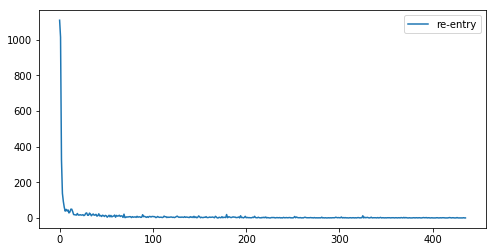

In [59]:
create_graph(df, 'booking_days', 'sum')

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [39]:
def corr_matrix(df):
    '''
    Creates a heatmap that shows the correlations between the different variables in a dataframe.
    
    Input:
        df: a dataframe
        title: name of the correlation_matrix
        
    Return:
        Outputs a heatmatrix showing correlations
    
    
    '''
    f, ax = plt.subplots(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, 
                mask=np.zeros_like(corr, dtype=np.bool), 
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

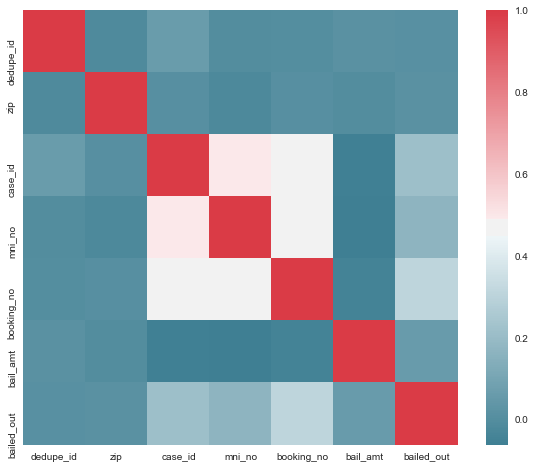

In [42]:
corr_matrix(df)

In [63]:
df.columns

Index(['mni_no', 'case_no', 'booking_no', 'arresting_agency', 'bail_type',
       'bail_amt', 're-entry', 'personid', 'dob', 'race', 'gender', 'city',
       'state', 'zip', 'age', 'booking_days', 'treatment_days',
       'mental_health'],
      dtype='object')

In [64]:
df = df.drop(['mni_no', 'case_no', 'booking_no', 'dob', 'personid'], axis=1)

In [65]:
df.to_csv('df.csv', index=False)